# Import libraries

In [192]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from models import *

# Load Datasets

In [193]:
drivers = Drivers()
drivers.df.drop(['url', 'dob', 'number', 'driverRef'], axis=1, inplace=True)

ps = Pit_Stops()
ps.df.drop(['time', 'duration'], axis=1, inplace=True)

results = Results()

races = Races()
races.df.drop(['time', 'url'], axis=1, inplace=True)

constructors = Contructors()
constructors.df.drop(['constructorRef', 'url'], axis=1, inplace=True)

# Get last X years of races

In [194]:
def filter_races_by_years(races, num_of_years = 5):
    """
    Filters the races dataframe to keep only races from the last 5 years.

    Parameters:
        races (DataFrame): DataFrame containing races information.

    Returns:
        DataFrame: Filtered DataFrame containing only races from the last 5 years.
    """
    current_year = datetime.now().year
    start_year = current_year - num_of_years
    return races[(races['year'] >= start_year) & (races['year'] <= current_year)]

In [195]:
races.df = filter_races_by_years(races.df)

# Get Active Drivers based on filtered races

In [196]:
def filter_active_drivers(drivers, races, results, threshold_percentage=.8):
    """
    Filters the drivers dataframe to keep only active drivers who have raced more than
    the given percentage of the races in the last 5 years.

    Parameters:
        drivers (DataFrame): DataFrame containing drivers information.
        races (DataFrame): DataFrame containing races information.
        results (DataFrame): DataFrame containing results information.
        threshold_percentage (float): Percentage threshold to define active drivers.

    Returns:
        DataFrame: Filtered DataFrame containing only active drivers.
    """

    # 1. Merge races with results to get driver participation in the last 5 years
    results = results.merge(races[['raceId', 'year']], on='raceId')

    # 2. Calculate total races in the last 5 years
    total_races_last_5_years = races['raceId'].nunique()

    # 3. Count number of races each driver has participated in during the last 5 years
    driver_participation_count = results.groupby('driverId')['raceId'].nunique().reset_index()
    driver_participation_count.rename(columns={'raceId': 'participation_count'}, inplace=True)

    # 4. Calculate the percentage of races each driver has participated in
    driver_participation_count['participation_percentage'] = (driver_participation_count['participation_count'] / total_races_last_5_years)

    # 5. Filter drivers based on the threshold percentage
    active_drivers_ids = driver_participation_count[driver_participation_count['participation_percentage'] > threshold_percentage]['driverId']

    # 6. Filter the drivers DataFrame to keep only active drivers
    active_drivers = drivers[drivers['driverId'].isin(active_drivers_ids)]
    return active_drivers

In [197]:
drivers.df = filter_active_drivers(drivers.df, races.df, results.df, threshold_percentage=.05)

In [198]:
print(drivers.df.shape)
drivers.df.head()

(30, 5)


,driverId,code,forename,surname,nationality
0,1,HAM,Lewis,Hamilton,British
3,4,ALO,Fernando,Alonso,Spanish
7,8,RAI,Kimi,Räikkönen,Finnish
8,9,KUB,Robert,Kubica,Polish
19,20,VET,Sebastian,Vettel,German


# Active Constructors

In [199]:
def filter_active_constructors(constructors, races, results):
    """
    Filters the constructors dataframe to keep only active constructors who have participated
    in at least one race in the last 5 years.

    Parameters:
        constructors (DataFrame): DataFrame containing constructors information.
        races (DataFrame): DataFrame containing races information.
        results (DataFrame): DataFrame containing results information.

    Returns:
        DataFrame: Filtered DataFrame containing only active constructors.
    """

    # 1. Merge races with results to get constructor participation in the last 5 years
    results = results.merge(races[['raceId', 'year']], on='raceId')

    # 2. Get the unique constructor IDs that have participated in the last 5 years
    active_constructors_ids = results['constructorId'].unique()

    # 3. Filter the constructors DataFrame to keep only active constructors
    active_constructors = constructors[constructors['constructorId'].isin(active_constructors_ids)]
    return active_constructors

In [200]:
constructors.df = filter_active_constructors(constructors.df, races.df, results.df)

In [201]:
print(constructors.df.shape)
constructors.df

(15, 3)


,constructorId,name,nationality
0,1,McLaren,British
2,3,Williams,British
3,4,Renault,French
4,5,Toro Rosso,Italian
5,6,Ferrari,Italian
8,9,Red Bull,Austrian
14,15,Sauber,Swiss
49,51,Alfa Romeo,Swiss
115,117,Aston Martin,British
129,131,Mercedes,German


# Handling Constructor Team Name Changes

We need to add in more mappings if # of years of races changes to handle more team name changes

In [202]:
def map_constructor_ids(df):
    """
    Maps constructor IDs to reflect name changes over the years.

    Parameters:
        df (DataFrame): DataFrame containing a constructorId column.

    Returns:
        DataFrame: DataFrame with updated constructorId to reflect name changes.
    """
    constructor_mapping = {
        4: 214,  # Renault -> Alpine F1 Team
        5: 215,  # Toro Rosso -> RB F1 Team
        51: 15,  # Alfa Romeo -> Sauber
        211: 117,  # Racing Point -> Aston Martin
        213: 215,  # AlphaTauri -> RB F1 Team
        10: 117, # Force India -> Aston Marting
    }
    df['constructorId'] = df['constructorId'].replace(constructor_mapping)
    return df

In [203]:
results.df = map_constructor_ids(results.df)

# Average Constructors Race Start and Finish Positions

In [204]:
def add_average_finish_and_grid_by_year(constructors, races, results):
    """
    Creates a new DataFrame that calculates the average finish position and average grid position
    for each constructor by year.

    Parameters:
        constructors (DataFrame): DataFrame containing constructors information.
        races (DataFrame): DataFrame containing races information.
        results (DataFrame): DataFrame containing results information.

    Returns:
        DataFrame: DataFrame with columns: constructorId, year, name, nationality, average_finish_position, average_grid_position.
    """
    # Merge results with races to get year information
    results_with_year = results.merge(races[['raceId', 'year']], on='raceId')

    # Calculate average finish position and grid position per race for each constructor by year
    results_grouped = results_with_year.groupby(['year', 'constructorId']).agg(
        avg_finish_position=('positionOrder', 'mean'),
        avg_grid_position=('grid', 'mean')
    ).reset_index()

    # Merge the calculated averages with the constructors DataFrame
    constructors_with_averages = results_grouped.merge(constructors, on='constructorId', how='left')

    # Select and reorder the desired columns
    constructors_with_averages = constructors_with_averages[['constructorId', 'year', 'name', 'nationality', 'avg_finish_position', 'avg_grid_position']]
    constructors_with_averages.rename(columns={
        'avg_finish_position': 'average_finish_position',
        'avg_grid_position': 'average_grid_position'
    }, inplace=True)

    return constructors_with_averages

In [205]:
constructors_with_averages = add_average_finish_and_grid_by_year(constructors.df, races.df, results.df)

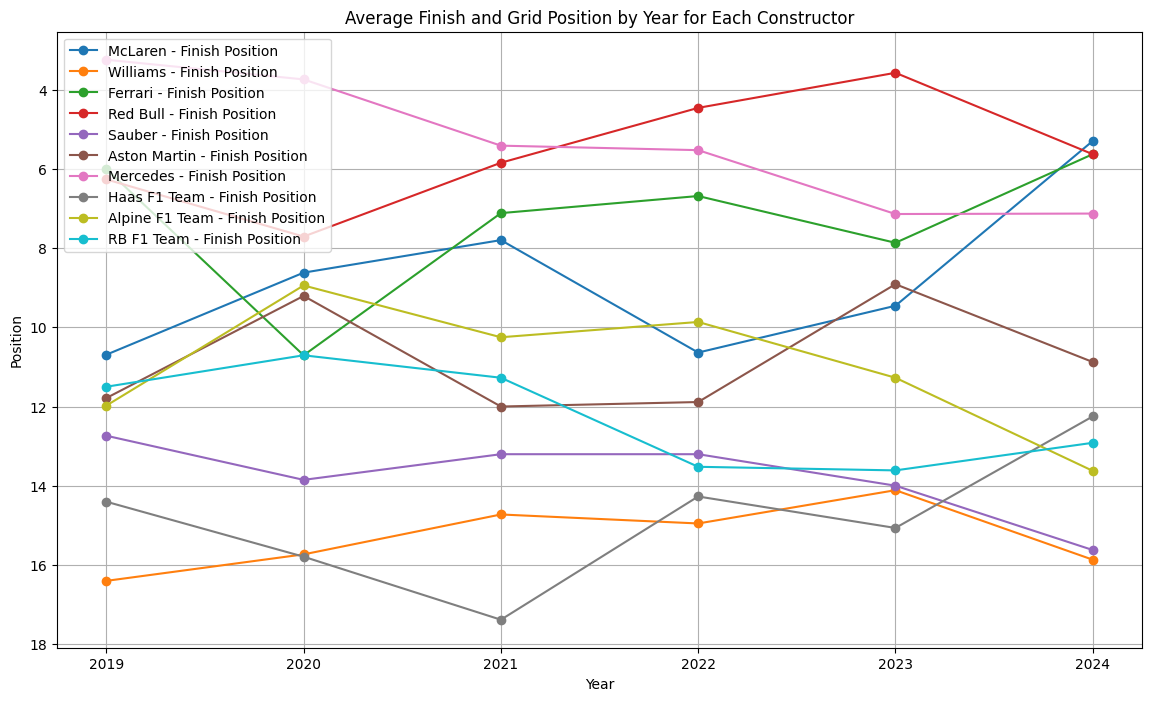

In [208]:
def plot_constructors_averages(constructors_with_averages):
    """
    Plots the average finish position and average grid position for each constructor by year.

    Parameters:
        constructors_with_averages (DataFrame): DataFrame containing constructor averages by year.
    """
    plt.figure(figsize=(14, 8))

    for constructor in constructors_with_averages['name'].unique():
        constructor_data = constructors_with_averages[constructors_with_averages['name'] == constructor]
        plt.plot(constructor_data['year'], constructor_data['average_finish_position'], marker='o', linestyle='-', label=f"{constructor} - Finish Position")
        # plt.plot(constructor_data['year'], constructor_data['average_grid_position'], marker='x', linestyle='--', label=f"{constructor} - Grid Position")

    plt.xlabel('Year')
    plt.ylabel('Position')
    plt.title('Average Finish and Grid Position by Year for Each Constructor')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

plot_constructors_averages(constructors_with_averages)